# 1. Import Dependencies and Data

In [1]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.JBF4QD_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.JBF4QD_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [ ]:
ds.as_numpy_iterator().next()['label']

2

In [ ]:
ds.take(1)

<_TakeDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

# 2. Vis Data and Build Dataset

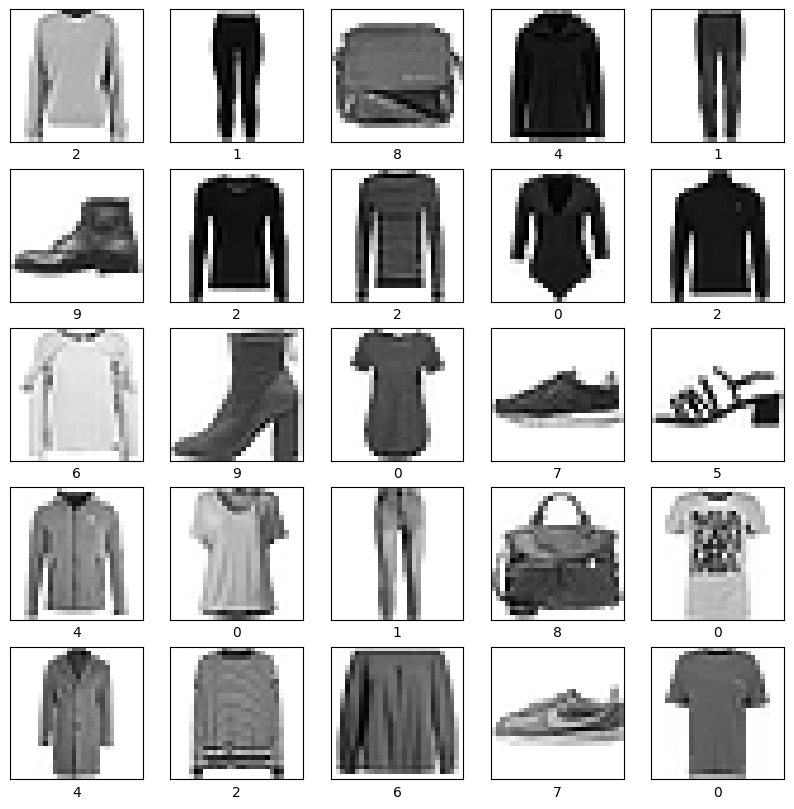

In [ ]:
import numpy as np

dataIterator = ds.as_numpy_iterator()
def get_images_and_labels(dataIterator, num_samples=25):
    images = []
    labels = []
    for _ in range(num_samples):
        data = dataIterator.next()
        images.append(data['image'])
        labels.append(data['label'])
    return np.array(images), np.array(labels)
images, labels = get_images_and_labels(dataIterator, 25)
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel(labels[i])

In [ ]:
def scale_images(data):
    image = data['image']
    return image/ 255

In [ ]:
ds = tfds.load('fashion_mnist', split='train')      # Load the Fashion MNIST training dataset (60,000 images)
ds = ds.map(scale_images)                           # Apply image scaling (e.g., normalize pixel values to 0–1)
ds = ds.cache()                                     # Cache data in memory or disk after preprocessing
ds = ds.shuffle(60000)                              # Randomly shuffle the dataset with buffer size = 60,000
ds = ds.batch(128)                                  # Group the dataset into batches of 128 samples
ds = ds.prefetch(64)                                # Prefetch 64 batches asynchronously to improve performance


In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

### 3.1 Import Modeling Component

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, BatchNormalization, Dropout, UpSampling2D

### 3.2 Build Generator

In [ ]:
def build_generator():
    model = Sequential()                          # Initialize a sequential neural network model

    model.add(Dense(7 * 7 * 128, input_dim=128)) # Fully connected layer transforming 128-dim noise to 7*7*128 units
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Reshape((7, 7, 128)))               # Reshape the output vector to a 3D tensor with shape 7x7x128

    model.add(UpSampling2D())                     # Upsample the feature map to double its size (14x14)
    model.add(Conv2D(128, 5, padding='same'))  # Convolutional layer with 128 filters, kernel size 5x5, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(UpSampling2D())                     # Upsample the feature map to double its size (28x28)
    model.add(Conv2D(128, 5, padding='same'))  # Convolutional layer with 128 filters, kernel size 5x5, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(Conv2D(128,4, padding='same'))  # Convolutional layer with 128 filters, kernel size 4x4, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(Conv2D(128, 4, padding='same'))  # Convolutional layer with 128 filters, kernel size 4x4, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))  # Final convolutional layer with 1 filter, kernel size 4x4, 'same' padding, and sigmoid activation

    return model                                 # Return the constructed generator model


In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_5 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

1/1 [==============================] - 0s 254ms/step


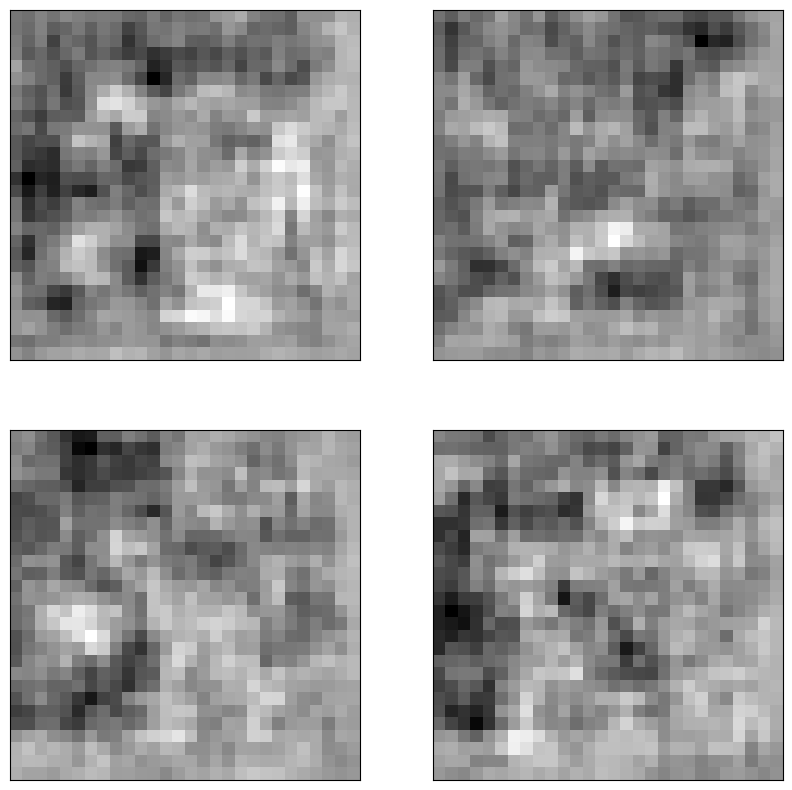

In [ ]:
img = generator.predict(np.random.randn(4, 128, 1))  # Generate 4 images from random noise vectors of size 128
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i].squeeze(), cmap=plt.cm.binary)  # Display each generated image in grayscale

In [ ]:
img.shape

(4, 28, 28, 1)

### 3.3 Build Descriminator

In [ ]:
def build_discriminator():
    model = Sequential()                          # Initialize a sequential neural network model

    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))  # Convolutional layer with 32 filters, kernel size 5x5, input shape 28x28x1
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Conv2D(64, 5))                            # Convolutional layer with 64 filters, kernel size 5x5
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Conv2D(128, 5))                           # Convolutional layer with 128 filters, kernel size 5x5
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Conv2D(256, 5))                           # Convolutional layer with 256 filters, kernel size 5x5
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Flatten())                                 # Flatten the output tensor to a 1D vector
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))  # Fully connected layer with 1 output unit and sigmoid activation for binary classification

    return model                                 # Return the constructed discriminator model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_15 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)     

In [ ]:
discriminator.predict(img)

1/1 [==============================] - 0s 168ms/step


array([[0.5067916 ],
       [0.50659186],
       [0.5066293 ],
       [0.50644857]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimization

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
import tensorflow as tf
tf.random.normal((6, 128, 1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 0.7858857 ],
        [ 0.91896486],
        [ 1.1439358 ],
        [ 0.5943322 ],
        [ 1.4541245 ],
        [ 0.8943216 ],
        [-1.2477987 ],
        [-0.64300627],
        [-0.8329567 ],
        [ 0.2150982 ],
        [ 0.24834421],
        [ 0.5803945 ],
        [ 1.271277  ],
        [ 2.396951  ],
        [-1.7073139 ],
        [-1.3455241 ],
        [-1.658387  ],
        [-1.4058055 ],
        [-0.09951411],
        [ 1.0718409 ],
        [ 0.04334628],
        [-0.07737852],
        [ 0.55210006],
        [-0.93269366],
        [ 0.5348378 ],
        [ 0.05512884],
        [-0.48405895],
        [ 0.17416357],
        [-1.3291807 ],
        [ 0.834116  ],
        [ 1.4179791 ],
        [ 0.31179753],
        [ 0.79325217],
        [-0.5093225 ],
        [ 1.2323675 ],
        [-0.9299724 ],
        [ 0.8042776 ],
        [-0.3973553 ],
        [-0.04291093],
        [-0.2210745 ],
        [-0.10001229],
    

In [ ]:


class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:

            # Pass the real and fake images to the discriminator
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the outputs
            noie_real = 0.15* tf.random.uniform(tf.shape(yhat_real))
            noie_fake = -0.15* tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noie_real, noie_fake], axis=0)

            # calculate the loss for real and fake images
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply the backproapagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # calculate the loss for fake images
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # apply the backproapagation - nn learn
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {'d_loss': total_d_loss, 'g_loss': total_g_loss}

In [ ]:
fashgan = FashionGAN(generator, discriminator)

In [ ]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [ ]:
import os
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_images = 3, latent_dim = 128):
        self.num_images = num_images
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_images, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_images):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('GANImages', f'epoch_{epoch}_image_{i}.png'))

### 4.4 Train

In [ ]:
hist = fashgan.fit(ds, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10
  8/469 [..............................] - ETA: 1:09:17 - d_loss: 0.6932 - g_loss: 0.6978

KeyboardInterrupt: 

### 4.5 Review Performance

# 5. Test out the Generator

### 5.1 Generate Images

### 5.2 Save the Model